### 前準備

In [1]:
# ============
# データのダウンロード
# ============
! wget http://www.phontron.com/kftt/download/kftt-data-1.0.tar.gz
! tar xvzf kftt-data-1.0.tar.gz
! rm /content/kftt-data-1.0.tar.gz
# ginzaのモデルをダウンロード
! pip install -U --quiet ja_ginza
# spacyのモデルをダウンロード
! python -m spacy download en_core_web_sm
# tensorboardのinstall
! pip install tensorboardX
# fairseqのインストール
! git clone https://github.com/pytorch/fairseq
% cd /content/fairseq/
! python -m pip install --editable .
% cd ..
import os
os.environ['PYTHONPATH'] += ":./fairseq/"
# apexのインストール
! rm -r /content/apex
! git clone https://github.com/NVIDIA/apex
% cd apex
! pip install --quiet -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
% cd ..
# Mecabのインストール
! sudo apt install mecab libmecab-dev mecab-ipadic-utf8 swig -y
! pip install mecab-python3 unidic-lite
! pip install fugashi
! pip install ipadic 
import MeCab
# SentencePieceの構築
! sudo apt-get install cmake build-essential pkg-config libgoogle-perftools-dev
! git clone https://github.com/google/sentencepiece.git 
% cd sentencepiece
! mkdir build
% cd build
! cmake ..
! make -j $(nproc)
! sudo make install
! sudo ldconfig -v
% cd ../..
! git clone https://github.com/Microsoft/vcpkg.git
% cd vcpkg
! ./bootstrap-vcpkg.sh
! ./vcpkg integrate install
! ./vcpkg install sentencepiece
% cd ..

--2022-03-02 10:26:39--  http://www.phontron.com/kftt/download/kftt-data-1.0.tar.gz
Resolving www.phontron.com (www.phontron.com)... 208.113.196.149
Connecting to www.phontron.com (www.phontron.com)|208.113.196.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99246893 (95M) [application/gzip]
Saving to: ‘kftt-data-1.0.tar.gz’

kftt-data-1.0.tar.g 100%[===================>]  94.65M  16.0MB/s    in 7.3s    

2022-03-02 10:26:47 (13.0 MB/s) - ‘kftt-data-1.0.tar.gz’ saved [99246893/99246893]

kftt-data-1.0/
kftt-data-1.0/data/
kftt-data-1.0/data/orig/
kftt-data-1.0/data/orig/kyoto-tune.en
kftt-data-1.0/data/orig/kyoto-dev.ja
kftt-data-1.0/data/orig/kyoto-dev.en
kftt-data-1.0/data/orig/kyoto-train.en
kftt-data-1.0/data/orig/kyoto-tune.ja
kftt-data-1.0/data/orig/kyoto-train.ja
kftt-data-1.0/data/orig/kyoto-test.ja
kftt-data-1.0/data/orig/kyoto-test.en
kftt-data-1.0/data/tok/
kftt-data-1.0/data/tok/kyoto-tune.en
kftt-data-1.0/data/tok/kyoto-dev.ja
kftt-data-1.0/dat

In [2]:
# ginzaで形態素解析
! mkdir -p /content/ginza-data
! cat kftt-data-1.0/data/orig/kyoto-train.ja | sed 's/\s+/ /g' | ginzame > /content/ginza-data/train.ginza.ja
! cat kftt-data-1.0/data/orig/kyoto-dev.ja | sed 's/\s+/ /g' | ginzame > /content/ginza-data/dev.ginza.ja
! cat kftt-data-1.0/data/orig/kyoto-test.ja | sed 's/\s+/ /g' | ginzame > /content/ginza-data/test.ginza.ja

In [3]:
! head -n 10 /content/ginza-data/test.ginza.ja

InfoboxBuddhist	名詞,普通名詞,一般,*,*,*,infoboxbuddhist,infoboxbuddhist,*
EOS

道元（どうげん）	名詞,固有名詞,人名,一般,*,*,道元,ドウゲン,*
は	助詞,係助詞,*,*,*,*,は,ハ,*
、	補助記号,読点,*,*,*,*,、,、,*
鎌倉	名詞,固有名詞,地名,一般,*,*,鎌倉,カマクラ,*
時代	名詞,普通名詞,一般,*,*,*,時代,ジダイ,*
初期	名詞,普通名詞,一般,*,*,*,初期,ショキ,*
の	助詞,格助詞,*,*,*,*,の,ノ,*


In [4]:
# ===========
# 90. データの準備
#============
# 日本語のトークン化
import spacy
! mkdir -p /content/data
for input, output in [
    ('/content/ginza-data/train.ginza.ja', '/content/data/train.ja'),
    ('/content/ginza-data/dev.ginza.ja', '/content/data/dev.ja'),
    ('/content/ginza-data/test.ginza.ja', '/content/data/test.ja'),
]:
    with open(input,'r') as f:
        contents = []
        temp = []
        for line in f:
            line = line.strip()
            if line == 'EOS':
                contents.append(' '.join(temp))
                temp = []
            elif line != '':
                temp.append(line.split('\t')[0])
    with open(output, 'w') as f:
        for content in contents:
            print(content, file=f)

# 英語のトークン化
import re
import spacy

nlp = spacy.load('en_core_web_sm')
for input, output in [
    ('/content/kftt-data-1.0/data/orig/kyoto-train.en', '/content/data/train.en'),
    ('/content/kftt-data-1.0/data/orig/kyoto-dev.en', '/content/data/dev.en'),
    ('/content/kftt-data-1.0/data/orig/kyoto-test.en', '/content/data/test.en'),
]:
    with open(input) as f, open(output, 'w') as g:
        for line in f:
            line = line.strip()
            line = re.sub(r'\s+', ' ', line)
            line = nlp.make_doc(line)
            line = ' '.join([doc.text for doc in line])
            print(line, file=g)

In [5]:
# ===========
# 91. 機械翻訳モデルの訓練
#============
# fairseqの前処理
! rm -r data-bin
SRC = "en"
TRG = "ja"
DATA_DIR = "/content/data"
! fairseq-preprocess \
    --source-lang $SRC \
    --target-lang $TRG \
    --trainpref $DATA_DIR/train \
    --validpref $DATA_DIR/dev \
    --testpref $DATA_DIR/test \
    --joined-dictionary \
    --nwordstgt 30000 \
    --nwordssrc 30000 \

rm: cannot remove 'data-bin': No such file or directory
`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-01 20:41:27 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=30000, nwordstgt=30000, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plas

In [6]:
# 訓練
! rm -r checkpoints
! fairseq-train data-bin --arch transformer \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --lr 3e-5 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
    --dropout 0.3 --clip-norm 0.0 \
    --optimizer adam --max-tokens 5000 --max-epoch 30 \
    --patience 5 --no-epoch-checkpoints > 91.log \

rm: cannot remove 'checkpoints': No such file or directory
epoch 001: 100% 2853/2854 [26:16<00:00,  1.89it/s, loss=8.503, nll_loss=7.519, ppl=183.43, wps=7056.7, ups=1.8, wpb=3927.5, bsz=172.3, num_updates=2800, lr=2.1e-05, gnorm=2.183, train_wall=55, gb_free=9.9, wall=1548]
epoch 001 | valid on 'valid' subset:   0% 0/11 [00:00<?, ?it/s]
epoch 001 | valid on 'valid' subset:   9% 1/11 [00:00<00:02,  4.12it/s]
epoch 001 | valid on 'valid' subset:  18% 2/11 [00:00<00:01,  4.69it/s]
epoch 001 | valid on 'valid' subset:  27% 3/11 [00:00<00:01,  5.26it/s]
epoch 001 | valid on 'valid' subset:  36% 4/11 [00:00<00:01,  5.37it/s]
epoch 001 | valid on 'valid' subset:  45% 5/11 [00:00<00:01,  5.12it/s]
epoch 001 | valid on 'valid' subset:  55% 6/11 [00:01<00:00,  5.16it/s]
epoch 001 | valid on 'valid' subset:  64% 7/11 [00:01<00:00,  5.16it/s]
epoch 001 | valid on 'valid' subset:  73% 8/11 [00:01<00:00,  5.08it/s]
epoch 001 | valid on 'valid' subset:  82% 9/11 [00:01<00:00,  5.00it/s]
epoch 001 | 

In [7]:
# モデルの保存
! cp /content/checkpoints/checkpoint_best.pt "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/ginza_spacy_epoch30.pt"

In [8]:
# ===========
# 92. 機械翻訳モデルの適用
#============
! mkdir -p /content/result90-94
DIR = "/content/result90-94"
! fairseq-generate data-bin \
   --path "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/ginza_spacy_epoch30.pt" \
   --batch-size 128 \
   --beam 5 > $DIR/result.txt

# 出力ファイルから生成文を抽出
! grep "^H-" $DIR/result.txt | sort -V | cut -f3 > $DIR/pred.txt

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-02 10:05:57 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': Fals

In [9]:
# ===========
# 93. BLEUスコアの計測
#============
REF_FILE = "/content/data/test.ja"
! fairseq-score --sys $DIR/pred.txt --ref $REF_FILE

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
Namespace(ignore_case=False, order=4, ref='/content/data/test.ja', sacrebleu=False, sentence_bleu=False, sys='/content/result90-94/pred.txt')
BLEU4 = 15.57, 43.6/19.9/11.0/6.7 (BP=0.981, ratio=0.981, syslen=26438, reflen=26951)


In [10]:
# ===========
# 94. ビーム探索
#============

for N in [1, 25, 50, 75, 100]:
    ! fairseq-generate data-bin --path "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/ginza_spacy_epoch30.pt" --batch-size 128 --max-tokens 1000 --beam $N > $DIR/result.txt
    ! grep "^H-" $DIR/result.txt | sort -V | cut -f3 > $DIR/pred.txt.$N

for N in [1, 25, 50, 75, 100]:
    ! fairseq-score --sys $DIR/pred.txt.$N --ref $REF_FILE > $DIR/BLEU.score.$N

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-02 10:06:39 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': Fals

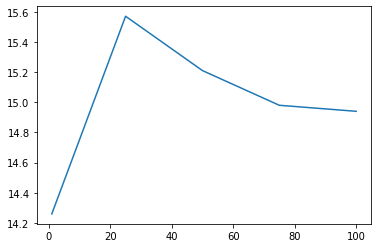

In [11]:
# グラフ化
import matplotlib.pyplot as plt
import re

def read_score(filename):
    with open(filename) as f:
        line = f.readlines()[1]
        line = re.search(r'(?<=BLEU4 = )\d*\.\d*(?=,)', line)
        return float(line.group())

x = [1, 25, 50, 75, 100]
y = [read_score(f'/content/result90-94/BLEU.score.{num}') for num in x]
plt.plot(x, y)
plt.show()

In [ ]:
# drop率を0.3から0.1に変更すると精度が下がった

In [2]:
# ===========
# 95. サブワード化
#============
! mkdir -p /content/data/spm
# sentencepieceモデルの作成
# ! spm_train --input=/content/kftt-data-1.0/data/orig/kyoto-train.en --model_prefix=/content/data/spm/spm_en --vocab_size=32000 --character_coverage=0.9995
# ! spm_train --input=/content/kftt-data-1.0/data/orig/kyoto-train.ja --model_prefix=/content/data/spm/spm_ja --vocab_size=32000 --character_coverage=0.9995
# /content/data/spm/spm_en と /content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_en.model は同じもの 
# /content/data/spm/spm_ja と /content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_ja.model は同じもの

! mkdir -p /content/data/spm_data
! spm_encode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_en.model" --output_format=piece < /content/kftt-data-1.0/data/orig/kyoto-train.en > /content/data/spm_data/train.en
! spm_encode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_en.model" --output_format=piece < /content/kftt-data-1.0/data/orig/kyoto-dev.en > /content/data/spm_data/dev.en
! spm_encode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_en.model" --output_format=piece < /content/kftt-data-1.0/data/orig/kyoto-test.en > /content/data/spm_data/test.en
! spm_encode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_ja.model" --output_format=piece < /content/kftt-data-1.0/data/orig/kyoto-train.ja > /content/data/spm_data/train.ja
! spm_encode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_ja.model" --output_format=piece < /content/kftt-data-1.0/data/orig/kyoto-dev.ja > /content/data/spm_data/dev.ja
! spm_encode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_ja.model" --output_format=piece < /content/kftt-data-1.0/data/orig/kyoto-test.ja > /content/data/spm_data/test.ja

In [26]:
# ===========
# 95. 91～94の繰り返し
#============
# 前処理
! rm -r data-bin
SRC = "en"
TRG = "ja"
DATA_DIR = "/content/data/spm_data"
! fairseq-preprocess \
    --source-lang $SRC \
    --target-lang $TRG \
    --trainpref $DATA_DIR/train \
    --validpref $DATA_DIR/dev \
    --testpref $DATA_DIR/test \
    --srcdict "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/dict.en.txt" \
    --tgtdict "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/dict.ja.txt" \

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-01 14:32:42 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_path='/tmp/plasma', profile=False, quantization_config_pat

In [ ]:
# 訓練
! rm -r /content/checkpoints
! fairseq-train data-bin --arch transformer \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --lr 3e-5 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
    --dropout 0.3 --clip-norm 0.0 \
    --optimizer adam --max-tokens 5000 --max-epoch 130 \
    --patience 5 --no-epoch-checkpoints --tensorboard-logdir log  \

In [ ]:
# モデルの保存
! cp /content/checkpoints/checkpoint_best.pt "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch130.pt"

In [27]:
# 翻訳文の生成
RESULT = "/content/result95"

# 翻訳文生成
! mkdir -p $RESULT
! fairseq-generate data-bin \
   --path "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch130.pt" --batch-size 128 --beam 5 > $RESULT/result.txt

# 翻訳文抽出
! grep "^H-" $RESULT/result.txt | sort -V | cut -f3 > $RESULT/pred.ja

# sentencepieceのdetokenize
! cat $RESULT/pred.ja | spm_decode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_ja.model" --input_format=piece > $RESULT/pred.detok.ja

# mecabによる単語分割
! cat $RESULT/pred.detok.ja | mecab -Owakati > $RESULT/pred.detok_mecab.ja
! cat /content/kftt-data-1.0/data/orig/kyoto-test.ja | mecab -Owakati > $RESULT/kyoto_test_mecab.ja

# BLEUスコアの計算
! fairseq-score --sys $RESULT/pred.detok_mecab.ja --ref $RESULT/kyoto_test_mecab.ja

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-01 14:35:34 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': Fals

In [28]:
# ビーム探索
RESULT_BEAM = "/content/result95_beam"
! mkdir -p $RESULT_BEAM
for N in [1, 25, 50, 75, 100]:
    ! fairseq-generate data-bin --path "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch130.pt" --batch-size 128 --max-tokens 1000 --beam $N > $RESULT_BEAM/result.txt
    ! grep "^H-" $RESULT_BEAM/result.txt | sort -V | cut -f3 > $RESULT_BEAM/pred.txt.$N
    ! cat $RESULT_BEAM/pred.txt.$N | spm_decode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_ja.model" --input_format=piece > $RESULT_BEAM/pred.detok.txt.$N
    ! cat $RESULT_BEAM/pred.detok.txt.$N | mecab -Owakati > $RESULT_BEAM/pred.detok_mecab.txt.$N

for N in [1, 25, 50, 75, 100]:
    ! fairseq-score --sys $RESULT_BEAM/pred.detok_mecab.txt.$N --ref $RESULT/kyoto_test_mecab.ja > $RESULT_BEAM/BLEU.score.$N

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-01 14:36:42 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': Fals

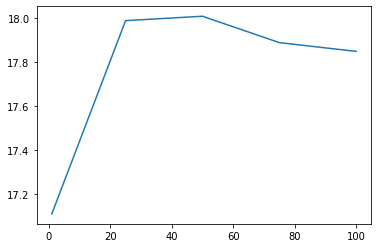

In [29]:
# グラフ化
import matplotlib.pyplot as plt
import re

def read_score(filename):
    with open(filename) as f:
        line = f.readlines()[1]
        line = re.search(r'(?<=BLEU4 = )\d*\.\d*(?=,)', line)
        return float(line.group())

x = [1, 25, 50, 75, 100]
y = [read_score(f'/content/result95_beam/BLEU.score.{num}') for num in x]
plt.plot(x, y)
plt.show()

In [31]:
# ===========
# 96. 学習過程の可視化
#============
! rm -r /content/checkpoints
! fairseq-train data-bin --arch transformer  --restore-file "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch130.pt"\
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --lr 3e-5 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
    --dropout 0.3 --clip-norm 0.0 \
    --optimizer adam --max-tokens 5000 --max-epoch 140 \
    --patience 5 --no-epoch-checkpoints --tensorboard-logdir log96 > 96.log \

rm: cannot remove '/content/checkpoints': No such file or directory
epoch 130: 100% 2847/2848 [13:26<00:00,  3.68it/s, loss=5.906, nll_loss=4.378, ppl=20.79, wps=11444.9, ups=3.61, wpb=3168.5, bsz=145.6, num_updates=370200, lr=3.11841e-06, gnorm=2.527, train_wall=27, gb_free=11.2, wall=798]
epoch 130 | valid on 'valid' subset:   0% 0/11 [00:00<?, ?it/s]
epoch 130 | valid on 'valid' subset:   9% 1/11 [00:00<00:02,  4.01it/s]
epoch 130 | valid on 'valid' subset:  18% 2/11 [00:00<00:01,  5.77it/s]
epoch 130 | valid on 'valid' subset:  36% 4/11 [00:00<00:00,  7.91it/s]
epoch 130 | valid on 'valid' subset:  45% 5/11 [00:00<00:00,  8.33it/s]
epoch 130 | valid on 'valid' subset:  55% 6/11 [00:00<00:00,  8.57it/s]
epoch 130 | valid on 'valid' subset:  64% 7/11 [00:00<00:00,  8.93it/s]
epoch 130 | valid on 'valid' subset:  73% 8/11 [00:00<00:00,  9.07it/s]
epoch 130 | valid on 'valid' subset:  82% 9/11 [00:01<00:00,  9.18it/s]
epoch 131: 100% 2847/2848 [13:21<00:00,  3.23it/s, loss=5.921, nll_l

In [50]:
! tensorboard --logdir "/content/log96" --host=localhost


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [32]:
# モデルの保存
! cp /content/checkpoints/checkpoint_best.pt "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch140.pt"

In [33]:
# ===========
# 97. ハイパーパラメータの調整（学習率を上げてepoch数を増やす）
#============
! rm -r /content/checkpoints
! fairseq-train data-bin --arch transformer  --restore-file "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch140.pt"\
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --lr 1e-4 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
    --dropout 0.3 --clip-norm 0.0 \
    --optimizer adam --max-tokens 5000 --max-epoch 150 \
    --patience 5 --no-epoch-checkpoints --tensorboard-logdir log97 > 97.log \

epoch 140: 100% 2847/2848 [13:23<00:00,  3.62it/s, loss=5.824, nll_loss=4.283, ppl=19.47, wps=11769.7, ups=3.57, wpb=3294.3, bsz=166.1, num_updates=398700, lr=1.00163e-05, gnorm=2.6, train_wall=28, gb_free=12, wall=800]
epoch 140 | valid on 'valid' subset:   0% 0/11 [00:00<?, ?it/s]
epoch 140 | valid on 'valid' subset:   9% 1/11 [00:00<00:01,  5.60it/s]
epoch 140 | valid on 'valid' subset:  27% 3/11 [00:00<00:00,  8.61it/s]
epoch 140 | valid on 'valid' subset:  45% 5/11 [00:00<00:00,  9.16it/s]
epoch 140 | valid on 'valid' subset:  55% 6/11 [00:00<00:00,  9.16it/s]
epoch 140 | valid on 'valid' subset:  64% 7/11 [00:00<00:00,  9.34it/s]
epoch 140 | valid on 'valid' subset:  73% 8/11 [00:00<00:00,  9.36it/s]
epoch 140 | valid on 'valid' subset:  82% 9/11 [00:00<00:00,  9.39it/s]
epoch 141: 100% 2847/2848 [13:19<00:00,  3.48it/s, loss=5.958, nll_loss=4.433, ppl=21.6, wps=11925.1, ups=3.45, wpb=3456.6, bsz=155.4, num_updates=401500, lr=9.9813e-06, gnorm=2.553, train_wall=29, gb_free=10.5, 

In [34]:
# モデルの保存
! cp /content/checkpoints/checkpoint_best.pt "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch150.pt"

In [35]:
# 翻訳文の生成
RESULT = "/content/result97"

# 翻訳文生成
! mkdir -p $RESULT
! fairseq-generate data-bin \
   --path "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch150.pt" --batch-size 128 --beam 5 > $RESULT/result.txt

# 翻訳文抽出
! grep "^H-" $RESULT/result.txt | sort -V | cut -f3 > $RESULT/pred.ja

# sentencepieceのdetokenize
! cat $RESULT/pred.ja | spm_decode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_ja.model" --input_format=piece > $RESULT/pred.detok.ja

# mecabによる単語分割
! cat $RESULT/pred.detok.ja | mecab -Owakati > $RESULT/pred.detok_mecab.ja
! cat /content/kftt-data-1.0/data/orig/kyoto-test.ja | mecab -Owakati > $RESULT/kyoto_test_mecab.ja

# BLEUスコアの計算
! fairseq-score --sys $RESULT/pred.detok_mecab.ja --ref $RESULT/kyoto_test_mecab.ja

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-01 19:51:14 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': Fals

In [36]:
# ビーム探索
RESULT_BEAM = "/content/result97_beam"
! mkdir -p $RESULT_BEAM
for N in [1, 25, 50, 75, 100]:
    ! fairseq-generate data-bin --path "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch150.pt" --batch-size 128 --max-tokens 1000 --beam $N > $RESULT_BEAM/result.txt
    ! grep "^H-" $RESULT_BEAM/result.txt | sort -V | cut -f3 > $RESULT_BEAM/pred.txt.$N
    ! cat $RESULT_BEAM/pred.txt.$N | spm_decode --model="/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_ja.model" --input_format=piece > $RESULT_BEAM/pred.detok.txt.$N
    ! cat $RESULT_BEAM/pred.detok.txt.$N | mecab -Owakati > $RESULT_BEAM/pred.detok_mecab.txt.$N

for N in [1, 25, 50, 75, 100]:
    ! fairseq-score --sys $RESULT_BEAM/pred.detok_mecab.txt.$N --ref $RESULT/kyoto_test_mecab.ja > $RESULT_BEAM/BLEU.score.$N

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-01 19:52:01 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': Fals

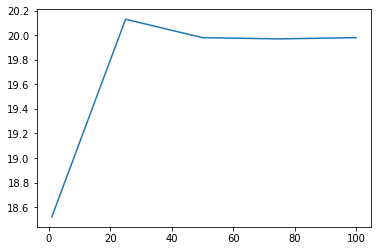

In [38]:
# グラフ化
import matplotlib.pyplot as plt
import re

def read_score(filename):
    with open(filename) as f:
        line = f.readlines()[1]
        line = re.search(r'(?<=BLEU4 = )\d*\.\d*(?=,)', line)
        return float(line.group())

x = [1, 25, 50, 75, 100]
y = [read_score(f'/content/result97_beam/BLEU.score.{num}') for num in x]
plt.plot(x, y)
plt.show()

In [2]:
# ===========
# 98. ドメイン適応（jparacrawlの事前学習済みモデルを利用する）
#============

# jparacrawlの事前学習済みモデルのダウンロード
! wget http://www.kecl.ntt.co.jp/icl/lirg/jparacrawl/release/1.0/pretrained_models/en-ja/base.tar.gz
! tar xzvf base.tar.gz
! rm base.tar.gz
! mv base ./pretrained_model_enja

# sentencepieceモデルのダウンロード
! mkdir -p /content/corpus
! wget http://www.kecl.ntt.co.jp/icl/lirg/jparacrawl/release/1.0/spm_models/en-ja_spm.tar.gz
! tar xzvf en-ja_spm.tar.gz
! rm en-ja_spm.tar.gz
! mv enja_spm_models /content/corpus

--2022-03-02 10:48:16--  http://www.kecl.ntt.co.jp/icl/lirg/jparacrawl/release/1.0/pretrained_models/en-ja/base.tar.gz
Resolving www.kecl.ntt.co.jp (www.kecl.ntt.co.jp)... 163.137.218.58
Connecting to www.kecl.ntt.co.jp (www.kecl.ntt.co.jp)|163.137.218.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 851521284 (812M) [application/x-gzip]
Saving to: ‘base.tar.gz’

base.tar.gz         100%[===================>] 812.07M  2.16MB/s    in 5m 46s  

2022-03-02 10:54:02 (2.35 MB/s) - ‘base.tar.gz’ saved [851521284/851521284]

base/
base/dict.en.txt
base/LICENSE
base/dict.ja.txt
base/base.pretrain.pt
--2022-03-02 10:54:12--  http://www.kecl.ntt.co.jp/icl/lirg/jparacrawl/release/1.0/spm_models/en-ja_spm.tar.gz
Resolving www.kecl.ntt.co.jp (www.kecl.ntt.co.jp)... 163.137.218.58
Connecting to www.kecl.ntt.co.jp (www.kecl.ntt.co.jp)|163.137.218.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1177051 (1.1M) [application/x-gzip]
Saving to: ‘en-ja

In [3]:
# 前処理（dataのsubword化）
! mkdir -p /content/corpus/spm_data
SPM_EN = "/content/corpus/enja_spm_models/spm.en.nopretok.model"
SPM_JA = "/content/corpus/enja_spm_models/spm.ja.nopretok.model"
KFTT_DATA = "/content/kftt-data-1.0/data/orig"
DATA_DIR = "/content/corpus/spm_data"
! spm_encode --model=$SPM_EN --output_format=piece < $KFTT_DATA/kyoto-train.en > $DATA_DIR/train.en
! spm_encode --model=$SPM_EN --output_format=piece < $KFTT_DATA/kyoto-dev.en > $DATA_DIR/valid.en
! spm_encode --model=$SPM_EN --output_format=piece < $KFTT_DATA/kyoto-test.en > $DATA_DIR/test.en
! spm_encode --model=$SPM_JA --output_format=piece < $KFTT_DATA/kyoto-train.ja > $DATA_DIR/train.ja
! spm_encode --model=$SPM_JA --output_format=piece < $KFTT_DATA/kyoto-dev.ja > $DATA_DIR/valid.ja
! spm_encode --model=$SPM_JA --output_format=piece < $KFTT_DATA/kyoto-test.ja > $DATA_DIR/test.ja

In [4]:
# fairseqの前処理
! rm -r data-bin
SRC = "en"
TRG = "ja"
DATA_DIR = "/content/corpus/spm_data"
SRC_DICT = "/content/pretrained_model_enja/dict.en.txt"
TGT_DICT = "/content/pretrained_model_enja/dict.ja.txt"
! fairseq-preprocess \
    --source-lang $SRC \
    --target-lang $TRG \
    --trainpref $DATA_DIR/train \
    --validpref $DATA_DIR/valid \
    --testpref $DATA_DIR/test \
    --srcdict $SRC_DICT \
    --tgtdict $TGT_DICT \

rm: cannot remove 'data-bin': No such file or directory
`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-02 10:54:34 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin', dict_only=False, empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_file=None, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, on_cpu_convert_precision=False, only_source=False, optimizer=None, padding_factor=8, plasma_pa

In [5]:
# 訓練　spm_epoch10_98.ptはjparacrawlの事前学習済みモデルをkfttでepoch数10だけ再学習したモデル
! rm -r /content/checkpoints
! fairseq-train data-bin --arch transformer --restore-file "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch10_98.pt" \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --lr 3e-5 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
    --dropout 0.3 --clip-norm 0.0 \
    --optimizer adam --max-tokens 5000 --max-epoch 20 \
    --patience 5 --no-epoch-checkpoints --tensorboard-logdir log98  \
    --reset-optimizer > 98.log \

rm: cannot remove '/content/checkpoints': No such file or directory
epoch 011: 100% 3330/3331 [16:14<00:00,  3.72it/s, loss=4.214, nll_loss=2.581, ppl=5.98, wps=12147.8, ups=3.45, wpb=3522.5, bsz=131.3, num_updates=3300, lr=2.475e-05, gnorm=1.461, train_wall=29, gb_free=11.5, wall=982]
epoch 011 | valid on 'valid' subset:   0% 0/13 [00:00<?, ?it/s]
epoch 011 | valid on 'valid' subset:   8% 1/13 [00:00<00:02,  4.66it/s]
epoch 011 | valid on 'valid' subset:  23% 3/13 [00:00<00:01,  8.70it/s]
epoch 011 | valid on 'valid' subset:  38% 5/13 [00:00<00:00,  9.64it/s]
epoch 011 | valid on 'valid' subset:  54% 7/13 [00:00<00:00,  9.71it/s]
epoch 011 | valid on 'valid' subset:  69% 9/13 [00:00<00:00,  9.79it/s]
epoch 011 | valid on 'valid' subset:  77% 10/13 [00:01<00:00,  9.60it/s]
epoch 011 | valid on 'valid' subset:  85% 11/13 [00:01<00:00,  9.65it/s]
epoch 012: 100% 3330/3331 [16:10<00:00,  3.52it/s, loss=4.23, nll_loss=2.599, ppl=6.06, wps=12507, ups=3.34, wpb=3740.9, bsz=119.5, num_updates

In [6]:
# モデルの保存
! cp /content/checkpoints/checkpoint_best.pt "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch20_98.pt"

In [7]:
SPM_EN = "/content/corpus/enja_spm_models/spm.en.nopretok.model"
SPM_JA = "/content/corpus/enja_spm_models/spm.ja.nopretok.model"

# 翻訳文の生成
RESULT = "/content/result98"

# 翻訳文生成
! mkdir -p $RESULT
! fairseq-generate data-bin \
   --path "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch20_98.pt" --batch-size 128 --beam 5 > $RESULT/result.txt

# 翻訳文抽出
! grep "^H-" $RESULT/result.txt | sort -V | cut -f3 > $RESULT/pred.ja

# sentencepieceのdetokenize
! cat $RESULT/pred.ja | spm_decode --model=$SPM_JA --input_format=piece > $RESULT/pred.detok.ja

# mecabによる単語分割
! cat $RESULT/pred.detok.ja | mecab -Owakati > $RESULT/pred.detok_mecab.ja
! cat /content/kftt-data-1.0/data/orig/kyoto-test.ja | mecab -Owakati > $RESULT/kyoto_test_mecab.ja

# BLEUスコアの計算
! fairseq-score --sys $RESULT/pred.detok_mecab.ja --ref $RESULT/kyoto_test_mecab.ja

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-02 13:41:28 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': Fals

In [8]:
# ビーム探索
RESULT_BEAM = "/content/result98_beam"
! mkdir -p $RESULT_BEAM
for N in [1, 25, 50, 75, 100]:
    ! fairseq-generate data-bin --path "/content/drive/MyDrive/Colab Notebooks/nlp100/chapter10/spm_epoch20_98.pt" --batch-size 128 --max-tokens 1000 --beam $N > $RESULT_BEAM/result.txt
    ! grep "^H-" $RESULT_BEAM/result.txt | sort -V | cut -f3 > $RESULT_BEAM/pred.txt.$N
    ! cat $RESULT_BEAM/pred.txt.$N | spm_decode --model=$SPM_JA --input_format=piece > $RESULT_BEAM/pred.detok.txt.$N
    ! cat $RESULT_BEAM/pred.detok.txt.$N | mecab -Owakati > $RESULT_BEAM/pred.detok_mecab.txt.$N

for N in [1, 25, 50, 75, 100]:
    ! fairseq-score --sys $RESULT_BEAM/pred.detok_mecab.txt.$N --ref $RESULT/kyoto_test_mecab.ja > $RESULT_BEAM/BLEU.score.$N

`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.
2022-03-02 13:41:59 | INFO | fairseq_cli.generate | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'log_file': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'on_cpu_convert_precision': False, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'amp': False, 'amp_batch_retries': 2, 'amp_init_scale': 128, 'amp_scale_window': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False, 'suppress_crashes': Fals

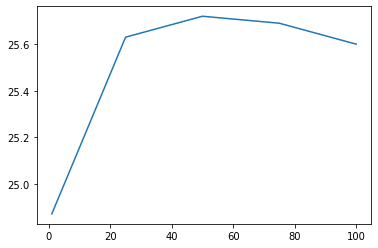

In [9]:
# グラフ化
import matplotlib.pyplot as plt
import re

def read_score(filename):
    with open(filename) as f:
        line = f.readlines()[1]
        line = re.search(r'(?<=BLEU4 = )\d*\.\d*(?=,)', line)
        return float(line.group())

x = [1, 25, 50, 75, 100]
y = [read_score(f'/content/result98_beam/BLEU.score.{num}') for num in x]
plt.plot(x, y)
plt.show()

In [ ]:
# ===========
# 99. 翻訳サーバの構築
#============
# 終了